Copyright 2025 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License

# Jupyter Notebook: Visualizing and Querying a Telco Network Graph in Spanner

**Goal:** This notebook demonstrates how to leverage Spanner Graph to model, visualize, and query a complex telecommunications network. We will start by loading realistic network data into Spanner tables, define a graph on top of this data, and then run a series of queries to uncover insights about the network's topology and health.

## 1. Setup and Configuration

Lets install and import required packages.

> `spanner-graph-notebook` provides a Jupyter magic interface to query and visualize Spanner Graphs.



In [ ]:
! pip install spanner-graph-notebook

In [ ]:
# @markdown Please fill in the value below with your Google Cloud project ID and then run the cell.

PROJECT_ID = "PROJECT-ID"  # @param {type:"string"}

# Set the project id
!gcloud config set project {PROJECT_ID}
%env GOOGLE_CLOUD_PROJECT={PROJECT_ID}

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import spanner

In [ ]:
# Replace with your project ID or get from env var
PROJECT_ID = "PROJECT-ID" #@param {type:"string"}

# Replace with your instance ID or get from env var
INSTANCE_ID = "SPANNER-INSTANCE-ID" #@param {type:"string"}

# Replace with your database ID or get from env var
DATABASE_ID = "DATABASE-ID" #@param {type:"string"}

## 2. Data Loading: From Avro to Spanner

We have a set of Avro files representing various aspects of our telco network as nodes in the Spanner Graph.

* `ENTITY`:	Master data repository for all identifiable network components.
* `PERFORMANCE`:	Stores time-series performance metrics for network entities.
* `CHANGEREQUEST`:	Tracks change requests related to network entities or services.
* `FAULTS`:	Records alarm and fault events generated by network entities.
* `TICKETS`:	Stores trouble tickets or incident reports.
* `NOTIFICATION`:	Stores records of notifications or advisories sent out.
* `INSIGHT`:	Stores derived insights, anomalies, or analytic results related to entities.

</br>
To join ENTITY to its PERFORMANCE, FAULTS, TICKETS etc. we also have avro files for relationship mapping:

* `EntityHasChangeRequest`:	Links entities to their change requests.
* `EntityHasNotification`:	Links entities to relevant notifications.
* `EntityHasFault`:	Links entities to their alarms/faults.
* `EntityToEdgePerformance`:	Performance metrics for links/edges between entities.
* `EntityHasTicket`:	Links entities to their trouble tickets.
* `EntityToEntity`:	Defines directed relationships or links between entities.
* `EntityHasPerformance`:	Explicitly links entities to their performance records.
* `EntityHasInsight`:	Explicitly links entities to their analytical insights.
* `EntityToNeighbor`:	General 'isNeighbor' relationship between entities.

Please use your favourite method of loading data into Spanner tables, Bigquery reverse ETL or Dataflow avro to Spanner template. Data files used in this notebook are provided in the data folder as `telco-notebook-data.tar.gz`

Lets first create the tables in Spanner :

In [ ]:
def execute_spanner_ddl(project_id, instance_id, database_id, schema_sql):
    """Creates tables in the Spanner database."""
    spanner_client = spanner.Client(project=project_id)
    instance = spanner_client.instance(instance_id)
    database = instance.database(database_id)

    print(schema_sql)

    operation = database.update_ddl(schema_sql)

    print('Waiting for operation to complete...')
    operation.result()
    print('Created tables/Propert Graph:')

**Spanner table DDLs for corresponding avro files**

In [ ]:
# Define the schema for each table
schema_sql = [
"""CREATE TABLE
  CHANGEREQUEST ( event_time TIMESTAMP,
    close_time TIMESTAMP,
    created_date TIMESTAMP,
    change_request_id STRING(MAX),
    implementor_id STRING(MAX),
    implementor_name STRING(MAX),
    requestor_id STRING(MAX),
    approver_id STRING(MAX),
    change_type_name STRING(MAX),
    status STRING(MAX),
    eid STRING(MAX),
    eid_directly_impacted_by_cr BOOL,
    source_system STRING(MAX),
    description STRING(MAX),
    labels JSON )
PRIMARY KEY
  (change_request_id)""",
"""CREATE TABLE
  ENTITY ( eid STRING(MAX),
    source_system STRING(MAX),
    last_updated TIMESTAMP,
    entity_type STRING(MAX),
    labels JSON,
    configuration JSON )
PRIMARY KEY
  (eid)""",
"""CREATE TABLE
  FAULTS ( time TIMESTAMP,
    clear_time TIMESTAMP,
    eid STRING(MAX),
    alarmid STRING(MAX),
    source_system STRING(MAX),
    cause_code STRING(MAX),
    labels JSON,
    alarm_severity STRING(MAX),
    alarm_status STRING(MAX),
    alarm_description STRING(MAX) )
PRIMARY KEY
  (eid,
    alarmid)""",
"""CREATE TABLE
  INSIGHT ( event_time TIMESTAMP,
    eid STRING(MAX),
    source_system STRING(MAX),
    labels JSON,
    metric JSON )
PRIMARY KEY
  (event_time,
    eid )""",
"""CREATE TABLE
  NOTIFICATION ( event_time TIMESTAMP,
    notification_id STRING(MAX),
    status STRING(MAX),
    eid STRING(MAX),
    source_system STRING(MAX),
    description STRING(MAX),
    labels JSON )
PRIMARY KEY
  (notification_id )""",
"""CREATE TABLE
  PERFORMANCE ( event_time TIMESTAMP,
    eid STRING(MAX),
    source_system STRING(MAX),
    labels JSON,
    metric JSON )
PRIMARY KEY
  (event_time,
    eid )""",
"""CREATE TABLE
  TICKETS ( event_time TIMESTAMP,
    resolved_time TIMESTAMP,
    ticketid STRING(MAX),
    eid STRING(MAX),
    source_system STRING(MAX),
    disposition_code STRING(MAX),
    description STRING(MAX),
    labels JSON )
PRIMARY KEY
  (ticketid)""",
"""CREATE TABLE
  EntityHasChangeRequest ( source_system STRING(MAX),
    change_request_id STRING(MAX),
    eid STRING(MAX) )
PRIMARY KEY
  (source_system,
    change_request_id,
    eid) """,
"""CREATE TABLE
  EntityHasFault ( source_system STRING(MAX),
    alarmid STRING(MAX),
    eid STRING(MAX) )
PRIMARY KEY
  (source_system,
    alarmid,
    eid) """,
"""CREATE TABLE
  EntityHasInsight ( event_time TIMESTAMP,
    source_system STRING(MAX),
    eid STRING(MAX) )
PRIMARY KEY
  (event_time,
    source_system,
    eid) """,
"""CREATE TABLE
  EntityHasNotification ( source_system STRING(MAX),
    notification_id STRING(MAX),
    eid STRING(MAX) )
PRIMARY KEY
  (source_system,
    notification_id,
    eid) """,
"""CREATE TABLE
  EntityHasPerformance ( event_time TIMESTAMP,
    source_system STRING(MAX),
    eid STRING(MAX) )
PRIMARY KEY
  (event_time,
    source_system,
    eid) """,
"""CREATE TABLE
  EntityHasTicket ( source_system STRING(MAX),
    ticketid STRING(MAX),
    eid STRING(MAX) )
PRIMARY KEY
  (source_system,
    ticketid,
    eid) """,
"""CREATE TABLE
  EntityToEdgePerformance ( event_time TIMESTAMP,
    source_system STRING(MAX),
    eid STRING(MAX),
    to_eid STRING(MAX),
    metric JSON )
PRIMARY KEY
  (event_time,
    source_system,
    eid,
    to_eid) """,
"""CREATE TABLE
  EntityToEntity ( event_time TIMESTAMP,
    source_system STRING(MAX),
    eid STRING(MAX),
    to_eid STRING(MAX) )
PRIMARY KEY
  (event_time,
    source_system,
    eid,
    to_eid) """,
"""CREATE TABLE
  EntityToNeighbor ( event_time TIMESTAMP,
    eid STRING(MAX),
    to_eid STRING(MAX) )
PRIMARY KEY
  (event_time,
    eid,
    to_eid)""",
"""ALTER TABLE  CHANGEREQUEST ADD COLUMN labels_tokens TOKENLIST AS (TOKENIZE_JSON(labels)) HIDDEN""",
"""CREATE SEARCH INDEX CHANGEREQUEST_labels_JSI ON CHANGEREQUEST (labels_tokens)""",
"""ALTER TABLE  ENTITY ADD COLUMN labels_tokens TOKENLIST AS (TOKENIZE_JSON(labels)) HIDDEN""",
"""CREATE SEARCH INDEX ENTITY_labels_JSI ON ENTITY (labels_tokens)""",
"""ALTER TABLE  ENTITY ADD COLUMN configuration_tokens TOKENLIST AS (TOKENIZE_JSON(configuration)) HIDDEN""" ,
"""CREATE SEARCH INDEX ENTITY_configuration_JSI ON ENTITY (configuration_tokens)""",
"""ALTER TABLE  FAULTS ADD COLUMN labels_tokens TOKENLIST AS (TOKENIZE_JSON(labels)) HIDDEN""",
"""CREATE SEARCH INDEX FAULTS_labels_JSI ON FAULTS (labels_tokens)""",
"""ALTER TABLE  INSIGHT  ADD COLUMN labels_tokens TOKENLIST AS (TOKENIZE_JSON(labels)) HIDDEN""",
"""CREATE SEARCH INDEX INSIGHT_labels_JSI ON INSIGHT (labels_tokens)""",
"""ALTER TABLE  INSIGHT  ADD COLUMN metric_tokens TOKENLIST AS (TOKENIZE_JSON(metric)) HIDDEN""",
"""CREATE SEARCH INDEX INSIGHT_metric_JSI ON INSIGHT (metric_tokens)""",
"""ALTER TABLE  NOTIFICATION  ADD COLUMN labels_tokens TOKENLIST AS (TOKENIZE_JSON(labels)) HIDDEN""",
"""CREATE SEARCH INDEX NOTIFICATION_labels_JSI ON NOTIFICATION (labels_tokens)""",
"""ALTER TABLE  PERFORMANCE  ADD COLUMN labels_tokens TOKENLIST AS (TOKENIZE_JSON(labels)) HIDDEN""",
"""CREATE SEARCH INDEX PERFORMANCE_labels_JSI ON PERFORMANCE (labels_tokens)""",
"""ALTER TABLE  PERFORMANCE  ADD COLUMN metric_tokens TOKENLIST AS (TOKENIZE_JSON(metric)) HIDDEN""",
"""CREATE SEARCH INDEX PERFORMANCE_metric_JSI ON PERFORMANCE (metric_tokens)""",
"""ALTER TABLE  TICKETS  ADD COLUMN labels_tokens TOKENLIST AS (TOKENIZE_JSON(labels)) HIDDEN""",
"""CREATE SEARCH INDEX TICKETS_labels_JSI ON TICKETS (labels_tokens)""",
"""ALTER TABLE  EntityToEdgePerformance ADD COLUMN metric_tokens TOKENLIST AS (TOKENIZE_JSON(metric)) HIDDEN""" ,
"""CREATE SEARCH INDEX EntityToEdgePerformance_metric_JSI ON EntityToEdgePerformance (metric_tokens)"""]

In [ ]:
# Call the function to create the tables
execute_spanner_ddl(PROJECT_ID, INSTANCE_ID, DATABASE_ID, schema_sql)

Once the tables are created in the Spanner database, we can load the avro data files into respcetive tables via **Avro to Spanner Dataflow Template**:
> https://cloud.google.com/dataflow/docs/guides/templates/provided/avro-to-cloud-spanner

## 3. Defining the Telco Network Graph

With our data loaded, we can now define a Spanner graph. This graph will be built on top of our existing tables, using the relationship mapping tables to define the edges between our network entities.


> Graph Schema



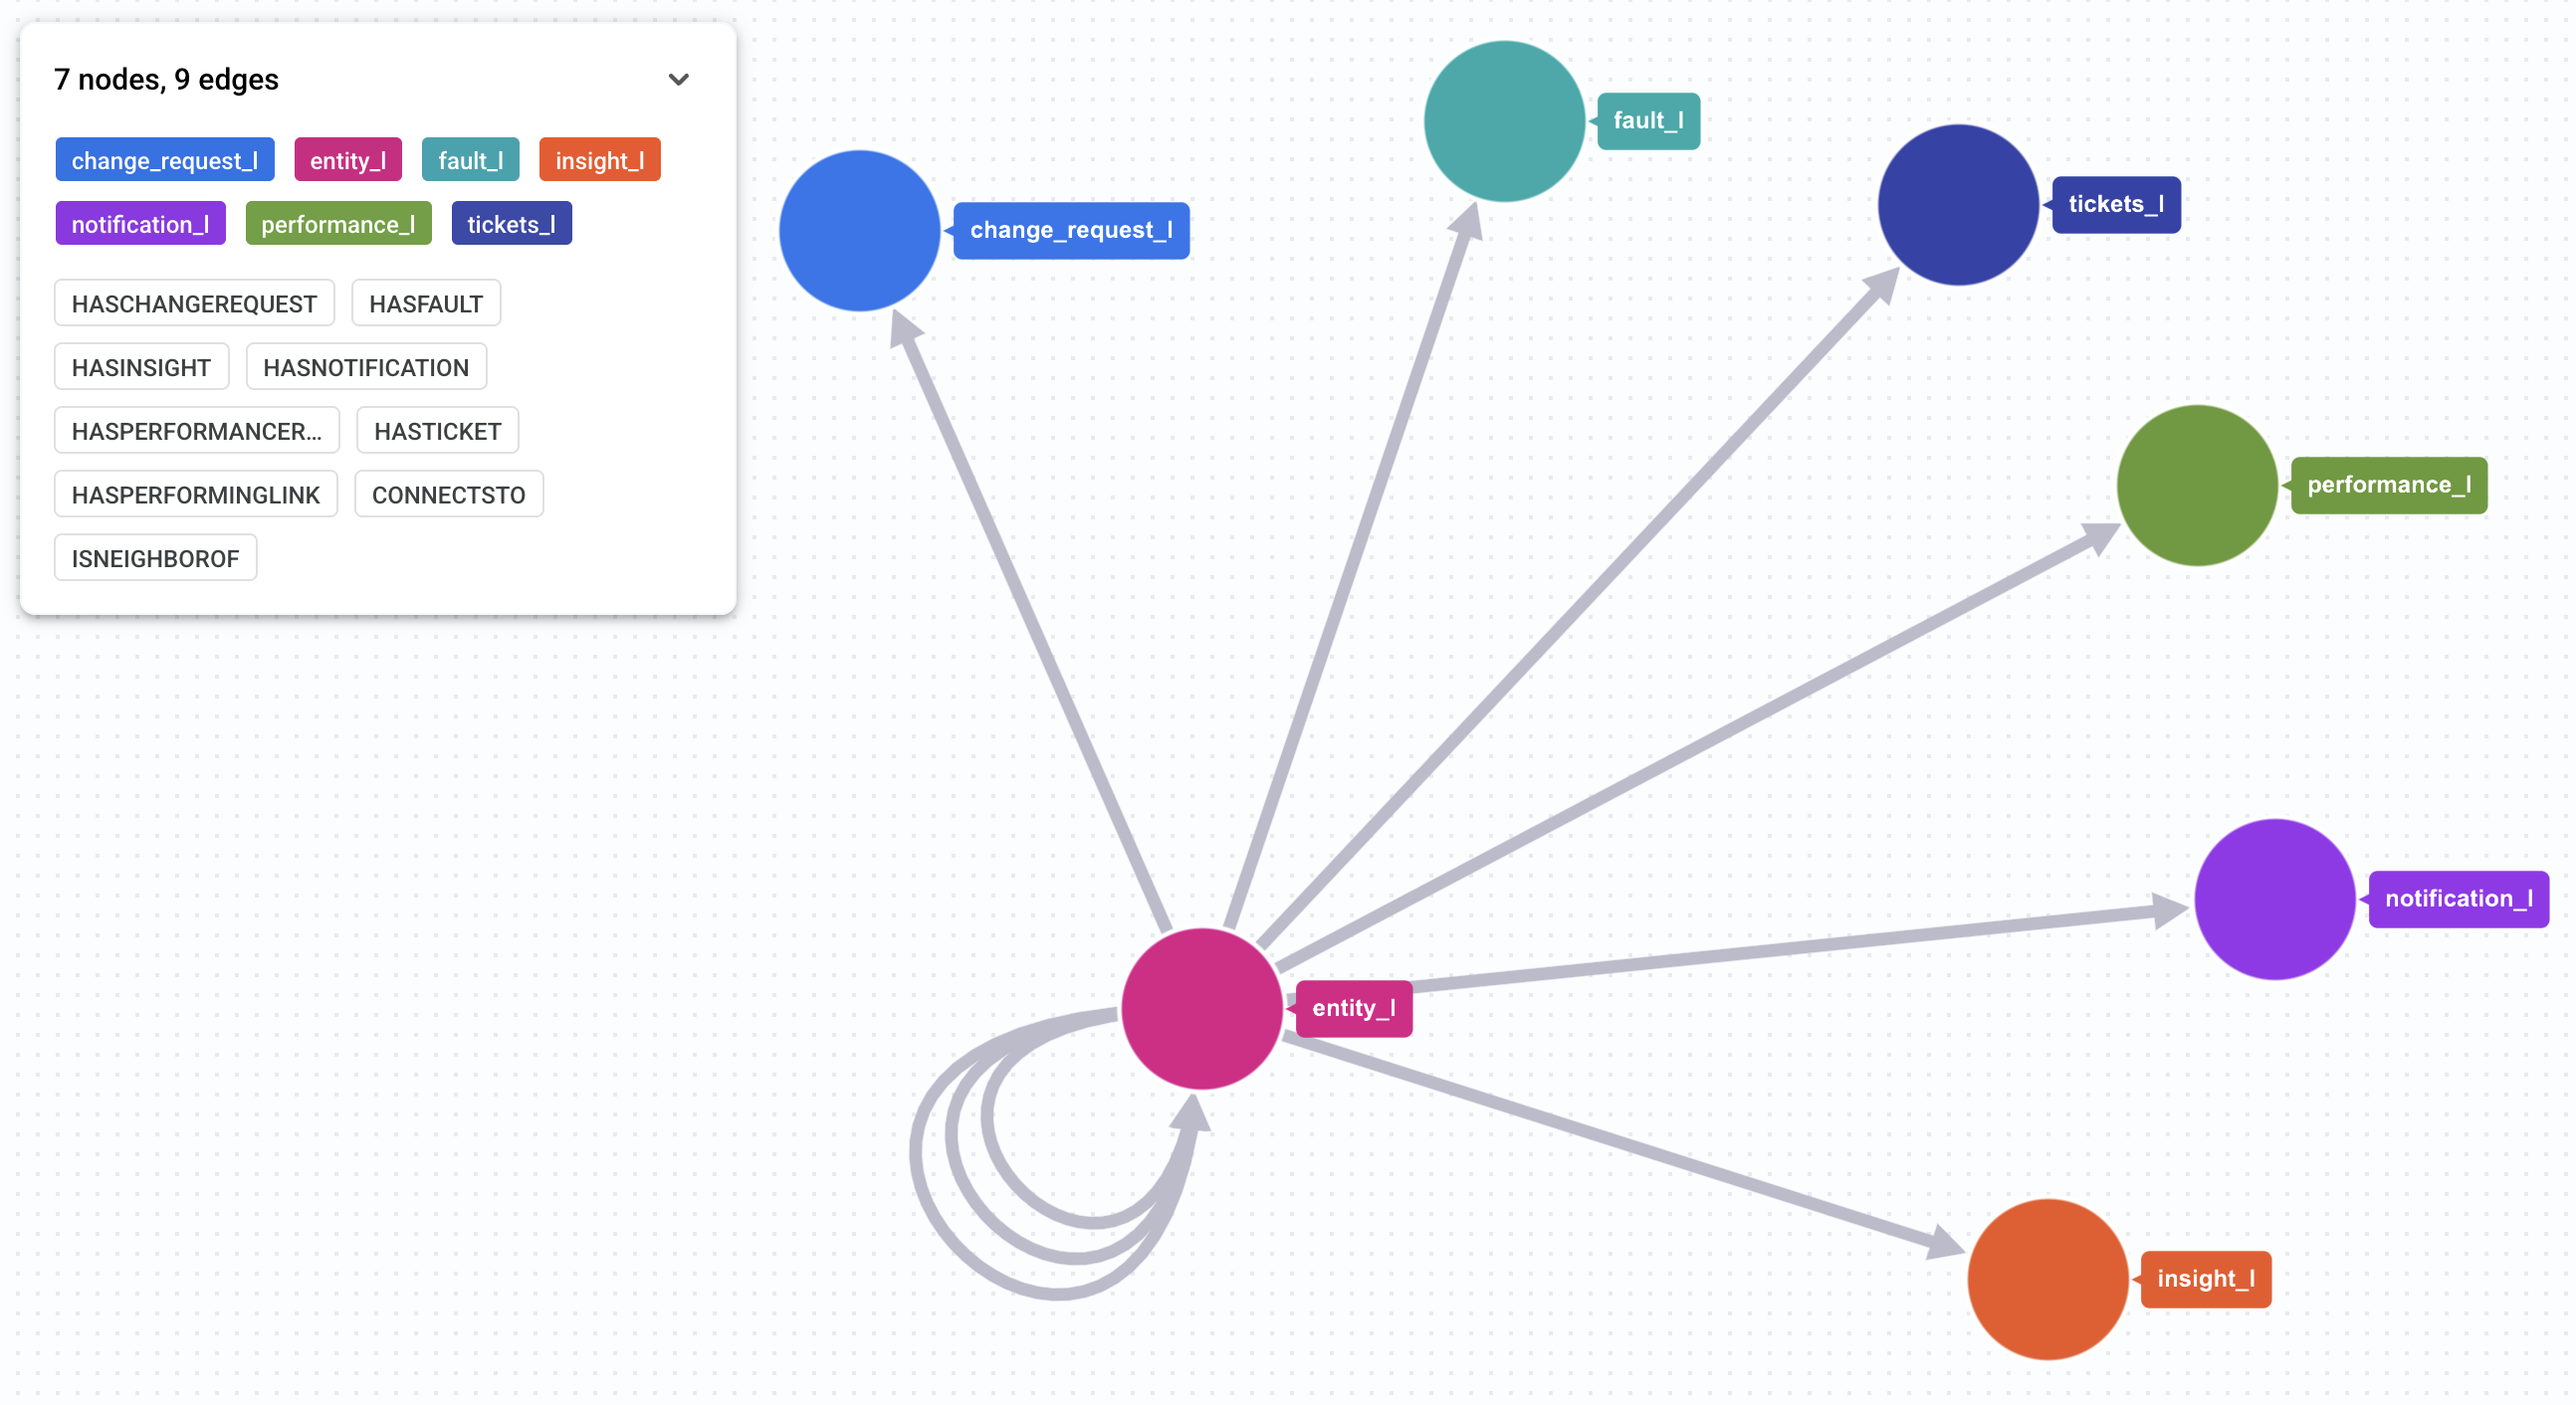

In [ ]:
property_graph_ddl = ["""
CREATE OR REPLACE PROPERTY GRAPH ComprehensiveTelcoNetworkGraph
  NODE TABLES (
    ENTITY as entity_n
      LABEL entity_l PROPERTIES ALL COLUMNS EXCEPT(labels_tokens, configuration_tokens),
    TICKETS as tickets_n
      LABEL tickets_l PROPERTIES ALL COLUMNS EXCEPT(labels_tokens),
    CHANGEREQUEST as change_request_n
      LABEL change_request_l PROPERTIES ALL COLUMNS EXCEPT(labels_tokens),
    FAULTS as fault_n
      LABEL fault_l PROPERTIES ALL COLUMNS EXCEPT(labels_tokens),
    INSIGHT as insight_n
      LABEL insight_l PROPERTIES ALL COLUMNS EXCEPT(labels_tokens, metric_tokens),
    PERFORMANCE as performance_n
      LABEL performance_l PROPERTIES ALL COLUMNS EXCEPT(labels_tokens, metric_tokens),
    NOTIFICATION as notification_n
      LABEL notification_l PROPERTIES ALL COLUMNS EXCEPT(labels_tokens)
  )
  EDGE TABLES (
    EntityHasTicket
      SOURCE KEY (eid) REFERENCES entity_n (eid)
      DESTINATION KEY (ticketid) REFERENCES tickets_n (ticketid)
      LABEL HasTicket,
    EntityHasChangeRequest
      SOURCE KEY (eid) REFERENCES entity_n (eid)
      DESTINATION KEY (change_request_id) REFERENCES change_request_n (change_request_id)
      LABEL HasChangeRequest,
    EntityToEntity
      SOURCE KEY (eid) REFERENCES entity_n (eid)
      DESTINATION KEY (to_eid) REFERENCES entity_n (eid)
      LABEL ConnectsTo PROPERTIES(event_time),
    EntityHasFault
      SOURCE KEY (eid) REFERENCES entity_n (eid)
      DESTINATION KEY (alarmid) REFERENCES fault_n (alarmid)
      LABEL HasFault,
    EntityHasInsight
       SOURCE KEY (eid) REFERENCES entity_n (eid)
       DESTINATION KEY (eid, event_time, source_system) REFERENCES insight_n (eid, event_time, source_system)
       LABEL HasInsight PROPERTIES(event_time),
    EntityHasPerformance
       SOURCE KEY (eid) REFERENCES entity_n (eid)
       DESTINATION KEY (eid, event_time, source_system) REFERENCES performance_n (eid, event_time, source_system)
       LABEL HasPerformanceRecord PROPERTIES(event_time),
    EntityHasNotification
       SOURCE KEY (eid) REFERENCES entity_n (eid)
       DESTINATION KEY (notification_id) REFERENCES notification_n (notification_id)
       LABEL HasNotification,
    EntityToNeighbor
       SOURCE KEY (eid) REFERENCES entity_n (eid)
       DESTINATION KEY (to_eid) REFERENCES entity_n (eid)
       LABEL IsNeighborOf PROPERTIES(event_time),
    EntityToEdgePerformance
       SOURCE KEY (eid) REFERENCES entity_n (eid)
       DESTINATION KEY (to_eid) REFERENCES entity_n (eid)
       LABEL HasPerformingLink PROPERTIES ALL COLUMNS EXCEPT(metric_tokens)
  )
"""]

In [ ]:
# Call the function to create the tables
execute_spanner_ddl(PROJECT_ID, INSTANCE_ID, DATABASE_ID, property_graph_ddl)

## 4. Visualizing and Querying the Graph

Now for the exciting part! We will use our defined graph to run a series of queries, from simple traversals to complex pattern matching. `spanner-graph-notebook` provides jupyter magics which simplifies querying and visualizing Spanner Graph.

#### Change the view to Top-down in the dropdown to view hierarchy graph.


A multi-hop query traversing over entities connected to entities

In [ ]:
%%spanner_graph --project $PROJECT_ID --instance $INSTANCE_ID --database $DATABASE_ID

GRAPH ComprehensiveTelcoNetworkGraph
MATCH p1 = (n1:entity_l {eid:"EID_000004"})-[e1:ConnectsTo]->(n2:entity_l)-[e2:ConnectsTo]->(n3:entity_l)-[e3:ConnectsTo]->(n4:entity_l)-[e4:ConnectsTo]->(n5:entity_l)
RETURN TO_JSON(p1) AS p1
LIMIT 100;

Neighboring entities with faults.

In [ ]:
%%spanner_graph --project $PROJECT_ID --instance $INSTANCE_ID --database $DATABASE_ID

GRAPH ComprehensiveTelcoNetworkGraph
MATCH p1 = (n1:entity_l {eid:"EID_000004"})-[e1:ConnectsTo]->(n2:entity_l)
MATCH p2 = (n1)-[e2:HasFault]->(n3:fault_l)
MATCH p3 = (n2)-[e3:HasFault]->(n4:fault_l)
RETURN
  TO_JSON(p1) AS p1,
  TO_JSON(p2) AS p2,
  TO_JSON(p3) AS p3
LIMIT 100;

All the neighbors of a given entity node.

In [ ]:
%%spanner_graph --project $PROJECT_ID --instance $INSTANCE_ID --database $DATABASE_ID

GRAPH ComprehensiveTelcoNetworkGraph
MATCH p1 = (n1:entity_l {eid:"EID_000847"})-[e1]->(n2)

RETURN
  TO_JSON(p1) AS p1

LIMIT 100;

An entity which has an active performance degradion fault and is connected to a CORE node which is 1 to 3 hops away.

In [ ]:
%%spanner_graph --project $PROJECT_ID --instance $INSTANCE_ID --database $DATABASE_ID

GRAPH ComprehensiveTelcoNetworkGraph
MATCH p1 = (n1:entity_l)-[e1:HasFault]->(n2:fault_l)
MATCH p2 = (n1)-[e2:ConnectsTo]->{2,4}(n3:entity_l)
WHERE
  JSON_CONTAINS(n1.labels, JSON '{"source_network_segment":"RAN"}')
  AND n2.alarm_status = "ACTIVE"
  AND n2.cause_code = "PERF_DEGRADATION_CHRONIC"
  AND JSON_CONTAINS(n3.labels, JSON '{"source_network_segment":"CORE"}')



RETURN
  TO_JSON(p1) AS p1,
  TO_JSON(p2) AS p2

LIMIT 100;

## Now Lets answer some questions:

List 10 RANs with oldest active faults due to performance degradation.

In [ ]:
%%spanner_graph --project $PROJECT_ID --instance $INSTANCE_ID --database $DATABASE_ID

GRAPH ComprehensiveTelcoNetworkGraph
MATCH ANY (n1:entity_l)-[e1:HasFault]->(n2:fault_l)
WHERE
  JSON_CONTAINS(n1.labels, JSON '{"source_network_segment":"RAN"}')
  AND n2.clear_time is NULL
  AND n2.alarm_status = "ACTIVE"
  AND n2.cause_code = "PERF_DEGRADATION_CHRONIC"
RETURN n1.eid, MIN(n2.time) as fault_start_time
GROUP BY n1.eid
ORDER BY fault_start_time ASC
limit 10

Lets filter a RAN node which has the longest active fault and facing performance degradation issues. We then want to travese up the chain to core nodes having active faults.

In [ ]:
%%spanner_graph --project $PROJECT_ID --instance $INSTANCE_ID --database $DATABASE_ID

GRAPH ComprehensiveTelcoNetworkGraph
MATCH p1 = (n1:entity_l)-[e1:HasFault]->(n2:fault_l)
WHERE
  JSON_CONTAINS(n1.labels, JSON '{"source_network_segment":"RAN"}')
  AND n2.clear_time is NULL
  AND n2.alarm_status = "ACTIVE"
  AND n2.cause_code = "PERF_DEGRADATION_CHRONIC"
ORDER BY n2.time ASC
limit 1
MATCH p2 = (n1)-[e2:ConnectsTo]->{1,4}(n3:entity_l)-[e3:ConnectsTo]->(n4:entity_l)-[e4:HasFault]->(n5:fault_l)
WHERE
  JSON_CONTAINS(n4.labels, JSON '{"source_network_segment":"CORE"}')
  AND n5.clear_time is NULL
  AND n5.alarm_status = "ACTIVE"
  AND n5.cause_code != "SECURITY_BREACH_SUSPECTED"

RETURN TO_JSON(p2) as p2
LIMIT 100

List the shortest path from the affected RAN node, which has the longest active fault, to a healthy CORE node

In [ ]:
%%spanner_graph --project $PROJECT_ID --instance $INSTANCE_ID --database $DATABASE_ID

GRAPH ComprehensiveTelcoNetworkGraph
-- Identify the RAN node with the longest active FAULT alarm
MATCH ANY (n1:entity_l)-[e1:HasFault]->(n2:fault_l)
WHERE
  JSON_CONTAINS(n1.labels, JSON '{"source_network_segment":"RAN"}')
  AND n2.clear_time is NULL
  AND n2.alarm_status = "ACTIVE"
  AND n2.cause_code = "PERF_DEGRADATION_CHRONIC"
LET e = n1, f = n2
RETURN e.eid as eid, MIN(f.time) as fault_start_time
GROUP BY eid
ORDER BY MIN(f.time) ASC
limit 1

NEXT

-- Shortest path from that RAN node to a healthy and working CORE node
MATCH p2 = ANY SHORTEST (n1:entity_l)-[e2:ConnectsTo]->(n3:entity_l)
              ( -- quantified path
                (n4:entity_l)-[e4:HasFault]->(n5:fault_l)
                WHERE
                  JSON_CONTAINS(n4.labels, JSON '{"source_network_segment":"CORE"}')
                  AND n5.clear_time is not NULL
                  AND n5.alarm_status = "CLEARED"
              ){1,3} -- quantified path

WHERE
  n1.eid = eid

RETURN TO_JSON(p2) as p2